# Plotting and analyzing the results

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Plotting the results](#plotting)\
   3.1. [Energy vs time](#ene_time)\
   3.2. [Average partial density of states](#ave_pdos)
      * 3.2.1. [Orbital resolved](#ave_pdos_1)
      * 3.2.2. [Atom resolved](#ave_pdos_2)
     
   3.3. [Excitation analysis](#exc_analysis)\
   3.4. [NAC map](#nac_map)\
   3.5. [NAMD results](#namd_res)
   
### A. Learning objectives

* To be able to plot the average partial density of states
* To be able to plot the computed excited states energies vs time
* To be able to plot the average CI coefficients
* To be able to plot the NAC map
* To be able to plot and analyze NAMD results

### B. Use cases


* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `data_stat`
    - [`cmat_distrib`](#nac_dist)
  - `workflows`
    - `nbra`
      - [`step2_many_body`](#exc_anal)
        - [`normalize_ci_coefficients`](#exc_anal)
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `packages`
    - `cp2k`
      - `methods`
        - [`read_cp2k_tddfpt_log_file`](#exc_anal)
  - `units`
    - `au2ev`

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library so that we can read the data. Import `numpy`, `scipy.sparse`, `CP2K_methods`, `data_stat`, `units`, and `step2_many_body` modules. `glob` library will be needed to find specific types of files and `scipy.optimize.curve_fit` will be used to fit the NAMD results.

In [1]:
import os
import glob
import h5py
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from libra_py import units, data_stat
import libra_py.packages.cp2k.methods as CP2K_methods
from libra_py.workflows.nbra import step2_many_body

/projects/academic/alexeyak/mohammad/software/mc/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/mc/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/mc/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: R

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

All of the pdos files are stored in this folder:

* `../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_pdosfiles`

All the logfiles containing the excitation analysis data are stored in this folder:

* `../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_logfiles`

All of the time-overlaps and nonadiabatic coupling matrices are stored in the cuurent directory and this folder:

* `res-mb-sd-DFT`

## 3. Plotting the results <a name="plotting"></a>
[Back to TOC](#toc)


### 3.1. Energy vs time <a name="ene_time"></a>

Here, we will plot the energies of the many-body and single-particle excitation bases

## NAMD results <a name="namd_res"></a>
[Back to TOC](#toc)


After the dynamic is done, we load all the NA-MD results, stored in `NBRA_icond_*/mem_data.hdf` files, using `h5py` and start fitting them to a exponential function of the form:

$$P(t; E_0)=\exp(-(\frac{t}{\tau})^2)$$


Then, the average time scale is computed for the fits that has an $R^2$ value more than $0.1$. The error bars are computed using the following formula as above:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $s$ is the stadard deviaton and $N$ is the number of samples (the ones that have $R^2$ value of more than $0.1$). The $Z$ value is the confidence interval coefficient which for confidence interval of $95\%$, a value of $1.96$ is chosen.

In above, we will consider the recovery dynamics population of the first and second excited states. Also, please note that this is just an example and we want to show how the workflow is. So, we consider a low $R^2$ value. For better and more accurate results, we need not only longer trajectory but also larger number of surface hopping trajectory.


In [8]:
def exp_func(t, tau):
    return np.exp(-np.power(t/tau,2))

tau: [15511.37556296]  R2: -inf


/projects/academic/alexeyak/mohammad/software/mc/envs/libra/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  


<IPython.core.display.Javascript object>


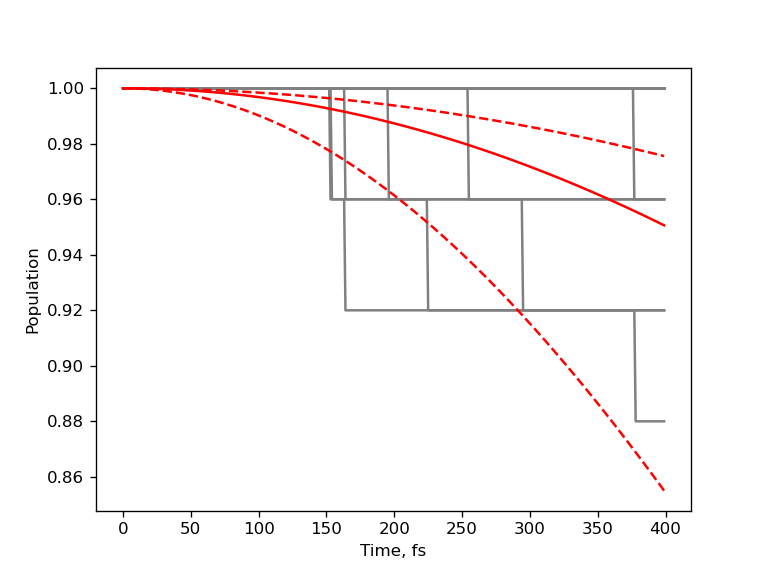

tau: [1098.23046537]  R2: 0.5555840509584433
tau: [1626.60796141]  R2: 0.6951161339709384
tau: [15511.37556296]  R2: -inf
tau: [1167.17235388]  R2: 0.9107878629747095
tau: [3830.1706442]  R2: 0.21021522541457882
tau: [1781.35098993]  R2: 0.7506843111998209
tau: [1134.95772981]  R2: 0.7724197456043077
tau: [15511.37556296]  R2: -inf
tau: [15511.37556296]  R2: -inf
The timescales: 1773.0816907665676+-764.9087039330117 fs, averaged over 6 samples


In [9]:
%matplotlib notebook
dt = 1
taus = []
for icond in range(0,200,20):
    F = h5py.File(F'NBRA_icond_{icond}/mem_data.hdf')
    sh_pop = np.array(F['sh_pop_adi/data'])
    F.close()
    md_time = np.arange(0,sh_pop.shape[0])*dt
    pop_recov = 1-np.sum(sh_pop[:,[1,2]], axis=1)
    popt, pcov = curve_fit( exp_func, md_time, pop_recov, bounds=([0.0],[np.inf]))
    tau = popt
    # Computing the R-squared
    residuals  = pop_recov - exp_func(md_time, *popt)
    ss_res     = np.sum(residuals**2)
    ss_tot     = np.sum((pop_recov - np.mean(pop_recov))**2)
    r_squared  = 1.0 - (ss_res / ss_tot)
    print('tau:', tau,  ' R2:', r_squared)

    if r_squared>0.1:
        taus.append(tau)
    plt.plot(md_time, pop_recov, color='gray')
plt.ylabel('Population')
plt.xlabel('Time, fs')

taus = np.array(taus)
ave_tau = np.average(taus)
s = np.std(taus)
Z = 1.96
N = taus.shape[0]
error_bar = Z*s/np.sqrt(N)
print(F'The timescales: {ave_tau}+-{error_bar} fs, averaged over {len(taus)} samples')
plt.plot(md_time, exp_func(md_time, ave_tau-error_bar), ls='--', color='red')
plt.plot(md_time, exp_func(md_time, ave_tau), ls='-',  color='red')
plt.plot(md_time, exp_func(md_time, ave_tau+error_bar), ls='--', color='red')